## ABSA analysis on full dataset
831k

Aspect-Based Sentiment Analysis (ABSA), also known as fine-grained opinion mining, is the task of determining the sentiment of a text with respect to a specific aspect.

1. Identify core text feature aspects via ABSA
2. Temporal changes in aspects over time
3. Store-wise comparison
4. RQ1: Which text feature aspects most strongly influence star ratings
5. RQ2: Which text feature aspects mostly predict review helpfulness(0-1 binary)

| Feature Group                | What it captures                     | Why it matters              |
| ---------------------------- | ------------------------------------ | --------------------------- |
| **Aspect Sentiment scores**  | Per-aspect polarity & intensity      | Main predictors for RQs     |
| **Aspect Mentions (binary)** | Which aspects are discussed          | Controls for omission bias  |
| **Review metadata**          | Rating, helpful votes, verified | Targets + confound controls |
| **Product identifiers**      | Category, brand, ASIN                | Clustering / fixed effects  |


#### 1. Aspect cleaning based on former result

In [37]:
import pandas as pd
import numpy as np

In [38]:
df = pd.read_csv('../data/absa_llm_results_831k_final.csv')

In [39]:
df

,id,text,aspect,sentiment,score
0,3,What a cute top! Cam wait to wear in warm weat...,Style,positive,0.8
1,1,Great,Unclassified,positive,0.8
2,0,I think this locket is really pretty. The insi...,Style,positive,0.8
3,0,I think this locket is really pretty. The insi...,Function,positive,0.7
4,0,I think this locket is really pretty. The insi...,Material,positive,0.6
...,...,...,...,...,...
1813086,831931,Y’all took to damn long I got it may 18th and ...,Shipping,negative,-0.8
1813087,831934,Great piece,Material,positive,0.8
1813088,831933,I bought this for my mom for Mother’s Day she ...,Material,positive,0.8
1813089,831933,I bought this for my mom for Mother’s Day she ...,Size,positive,0.9


In [40]:
amazon = pd.read_csv('../data/joined_data.csv')

In [41]:
df.shape

(1813091, 5)

In [42]:
amazon.shape

(831935, 22)

In [43]:
# --- 3. Core Transformation Logic: Aggregate to Lists ---
# Group by 'id', aggregate aspect, sentiment, score into lists
df_wide = df.groupby('id').agg({
    'aspect': list,
    'sentiment': list,
    'score': list
}).reset_index()


print(f"✅ Aggregation complete! Wide-format data contains {len(df_wide)} reviews with aspects.")

# --- 4. Merge with Original DataFrame (Restore Metadata) ---
# Assuming the original data variable in your environment is named 'amazon'
if 'amazon' in locals():
    print("🔄 Merging with original DataFrame 'amazon'...")
    
    # Merge df_wide (aggregated ABSA results) with amazon (original review data)
    # Use 'id' as the key, which corresponds to the index in amazon
    df_wide['id'] = df_wide['id'].astype(int)
    amazon_with_index = amazon.reset_index(drop=True)
    amazon_with_index['id'] = amazon_with_index.index
    
    # Left merge: Keep all rows from amazon, add ABSA results where available
    final_df = pd.merge(amazon_with_index, df_wide, on='id', how='left', suffixes=('', '_absa'))
    
    # --- 5. Data Cleaning: Handle Null Values ---
    # Reviews with no extracted aspects will be NaN after merge; we need to fill them with empty lists []
    print("🧹 Cleaning data: Filling null values with [] ...")
    
    cols_to_fix = ['aspect', 'sentiment', 'score']
    
    for col in cols_to_fix:
        # Use apply to fill NaN with empty lists
        # Note: Checks if x is a list; if not (i.e., NaN), fills with []
        final_df[col] = final_df[col].apply(lambda x: x if isinstance(x, list) else [])

    # --- 6. Display Results ---
    print("\n🎉 Conversion Successful! Final DataFrame Preview:")
    print(final_df[['text', 'aspect', 'sentiment', 'score']].head(5))
    

else:
    print("⚠️ Warning: Original variable 'df' not found in environment.")
    print("   Generated df_wide containing only ABSA results.")
    print(df_wide.head())
    final_df = df_wide

✅ Aggregation complete! Wide-format data contains 824251 reviews with aspects.
🔄 Merging with original DataFrame 'amazon'...
🧹 Cleaning data: Filling null values with [] ...

🎉 Conversion Successful! Final DataFrame Preview:
                                                text  \
0  I think this locket is really pretty. The insi...   
1                                              Great   
2  Works OK for adults and is not at all kid frie...   
3  What a cute top! Cam wait to wear in warm weat...   
4  My son is a big Ninjago fan and these are perf...   

                                      aspect                       sentiment  \
0                [Style, Function, Material]  [positive, positive, positive]   
1                             [Unclassified]                      [positive]   
2                            [Service, Size]            [negative, negative]   
3                                    [Style]                      [positive]   
4  [Service, Print, Washing, Material,

In [44]:
final_df.columns

Index(['rating', 'title_x', 'text', 'images_x', 'asin', 'parent_asin',
       'user_id', 'timestamp', 'helpful_vote', 'verified_purchase',
       'main_category', 'title_y', 'average_rating', 'rating_number',
       'features', 'description', 'price', 'images_y', 'videos', 'store',
       'categories', 'details', 'id', 'aspect', 'sentiment', 'score'],
      dtype='object')

In [45]:
keep_cols = [
    'parent_asin', 'store', 'timestamp', 'user_id', 'rating', 'text',
    'helpful_vote', 'verified_purchase',
    'aspect', 'sentiment', 'score'
]

merged_min = final_df[keep_cols].copy()


In [46]:
merged_min

,parent_asin,store,timestamp,user_id,rating,text,helpful_vote,verified_purchase,aspect,sentiment,score
0,B00LOPVX74,CHUVORA,2020-01-09 00:06:34.489,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,5.0,I think this locket is really pretty. The insi...,3,True,"[Style, Function, Material]","[positive, positive, positive]","[0.8, 0.7, 0.6]"
1,B07B4JXK8D,PrimeMed,2020-12-20 01:04:06.701,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,5.0,Great,0,True,[Unclassified],[positive],[0.8]
2,B089S8MFCQ,Kranchungel,2020-10-21 18:58:06.690,AHTTU2FL6FCNBBAESCJHOHHSSW7A,3.0,Works OK for adults and is not at all kid frie...,0,True,"[Service, Size]","[negative, negative]","[-0.5, -0.6]"
3,B087M39LVV,Twotwowin,2022-01-20 23:38:14.143,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,5.0,What a cute top! Cam wait to wear in warm weat...,0,True,[Style],[positive],[0.8]
4,B091GMMYPS,Melitolay,2022-02-04 18:48:28.824,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,5.0,My son is a big Ninjago fan and these are perf...,0,True,"[Service, Print, Washing, Material, Size]","[pos, pos, pos, pos, neu]","[0.8, 0.7, 0.6, 0.7, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...
831930,B07HF4F6LP,Charmed Craft,2021-05-30 23:42:42.440,AG4N46GFOECH7THIIQWVBVKCIS2Q,5.0,Super cute!,0,True,[Style],[positive],[0.8]
831931,B07HF4F6LP,Charmed Craft,2020-05-18 21:22:06.602,AGUGFDHYUKELUZTJU3373XO2QVGA,1.0,Y’all took to damn long I got it may 18th and ...,0,True,[Shipping],[negative],[-0.8]
831932,B07HF4F6LP,Charmed Craft,2021-02-10 19:54:42.236,AH7PTXXCYHBGJN2KMKMTGI6NBV4A,1.0,It should have had enshrined on both sides,0,True,[Unclassified],[none],[0.0]
831933,B07HF4F6LP,Charmed Craft,2020-07-16 17:43:12.373,AH7Q2PTD6CLQVTLM6MQCYWP5ZOVA,5.0,I bought this for my mom for Mother’s Day she ...,0,True,"[Material, Size, Service]","[positive, positive, positive]","[0.8, 0.9, 0.7]"


In [47]:
# convert helpful_vote to binary value - because there are lots of 0 in this column
merged_min['helpful_binary'] = (merged_min['helpful_vote'] > 0).astype(int)


In [48]:
# create feature columns for each target aspect

target_aspects = ['Unclassified', 'Clips', 'Comfort', 'Service', 'Print', 'Function', 'Washing', 'Visuals', 'Style', 'Price', 'Shipping', 'Material', 'Size']

# Convert string columns (e.g., JSON format) to Python lists
for col in ['aspect', 'sentiment', 'score']:
    merged_min[col] = merged_min[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize feature columns for each aspect
for asp in target_aspects:
    merged_min[f'{asp}_exist'] = 0
    merged_min[f'{asp}_score'] = 0.0

# Iterate through each row
for idx, row in merged_min.iterrows():
    aspects = row['aspect']
    sentiments = row['sentiment']
    confidences = row['score']

    if not isinstance(aspects, list):
        continue

    # Store scores for each aspect
    aspect_scores = {a: [] for a in target_aspects}

    for a, s, c in zip(aspects, sentiments, confidences):
        if a not in target_aspects:
            continue

        # Convert sentiment direction: Positive=+c, Negative=-c, Neutral=0
        # Skip if sentiment is NaN or not a string
        if not isinstance(s, str):
            continue
        
        if s.lower() == 'positive':
            signed_c = c
        elif s.lower() == 'negative':
            signed_c = c
        else:
            signed_c = 0

        aspect_scores[a].append(signed_c)

    # Aggregate results
    for a in target_aspects:
        if aspect_scores[a]:  # If aspect is mentioned
            merged_min.at[idx, f'{a}_exist'] = len(aspect_scores[a])
            merged_min.at[idx, f'{a}_score'] = np.mean(aspect_scores[a])  # Average score

# Extract feature columns
feature_cols = [col for col in merged_min.columns if any(a in col for a in target_aspects)]


In [49]:
merged_use = merged_min.dropna(subset=['store', 'verified_purchase','rating'])

In [50]:
merged_use.shape

(828449, 38)

In [51]:
merged_use.head(20)

,parent_asin,store,timestamp,user_id,rating,text,helpful_vote,verified_purchase,aspect,sentiment,...,Style_exist,Style_score,Price_exist,Price_score,Shipping_exist,Shipping_score,Material_exist,Material_score,Size_exist,Size_score
0,B00LOPVX74,CHUVORA,2020-01-09 00:06:34.489,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,5.0,I think this locket is really pretty. The insi...,3,True,"[Style, Function, Material]","[positive, positive, positive]",...,1,0.8,0,0.0,0,0.0,1,0.60,0,0.00
1,B07B4JXK8D,PrimeMed,2020-12-20 01:04:06.701,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,5.0,Great,0,True,[Unclassified],[positive],...,0,0.0,0,0.0,0,0.0,0,0.00,0,0.00
2,B089S8MFCQ,Kranchungel,2020-10-21 18:58:06.690,AHTTU2FL6FCNBBAESCJHOHHSSW7A,3.0,Works OK for adults and is not at all kid frie...,0,True,"[Service, Size]","[negative, negative]",...,0,0.0,0,0.0,0,0.0,0,0.00,1,-0.60
3,B087M39LVV,Twotwowin,2022-01-20 23:38:14.143,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,5.0,What a cute top! Cam wait to wear in warm weat...,0,True,[Style],[positive],...,1,0.8,0,0.0,0,0.0,0,0.00,0,0.00
4,B091GMMYPS,Melitolay,2022-02-04 18:48:28.824,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,5.0,My son is a big Ninjago fan and these are perf...,0,True,"[Service, Print, Washing, Material, Size]","[pos, pos, pos, pos, neu]",...,0,0.0,0,0.0,0,0.0,1,0.00,1,0.00
5,B09DQ5M2BB,snugwind,2021-10-21 04:50:43.960,AHREXOGQPZDA6354MHH4ETSF3MCQ,2.0,There are lots of raw edges. Not well made. ...,1,True,"[Material, Style, Size]","[negative, negative, negative]",...,1,-0.6,0,0.0,0,0.0,1,-0.70,1,-0.40
6,B095M3HHTJ,ASTANFY,2021-08-16 02:17:44.160,AHREXOGQPZDA6354MHH4ETSF3MCQ,5.0,I really liked this shirt when I received it. ...,1,True,"[Style, Material, Material, Size, Size, Style]","[positive, positive, positive, negative, posit...",...,2,0.7,0,0.0,0,0.0,2,0.65,2,0.10
7,B089PWHFVW,Upopby,2021-08-13 15:09:46.110,AHREXOGQPZDA6354MHH4ETSF3MCQ,3.0,"If you are large chested, this isn’t for you. ...",0,False,"[Size, Material, Size, Style, Material]","[negative, neutral, positive, positive, positive]",...,1,0.6,0,0.0,0,0.0,2,0.25,2,-0.05
8,B097DQPCP2,JULYCLO,2021-07-27 13:17:50.221,AHREXOGQPZDA6354MHH4ETSF3MCQ,5.0,I really like this Tshirt. Quality fabric. S...,3,True,"[Material, Comfort, Style, Material, Size, Size]","[positive, positive, positive, positive, neutr...",...,1,0.6,0,0.0,0,0.0,2,0.60,2,0.20
9,B092J4ZT1V,KAPUCTW,2021-06-10 13:41:03.658,AHREXOGQPZDA6354MHH4ETSF3MCQ,5.0,I received this T the other day. I took it ou...,0,True,"[Shipping, Material, Style, Size, Comfort]","[positive, positive, positive, positive, posit...",...,1,0.8,0,0.0,1,0.8,1,0.90,1,0.90


In [52]:
merged_use.columns

Index(['parent_asin', 'store', 'timestamp', 'user_id', 'rating', 'text',
       'helpful_vote', 'verified_purchase', 'aspect', 'sentiment', 'score',
       'helpful_binary', 'Unclassified_exist', 'Unclassified_score',
       'Clips_exist', 'Clips_score', 'Comfort_exist', 'Comfort_score',
       'Service_exist', 'Service_score', 'Print_exist', 'Print_score',
       'Function_exist', 'Function_score', 'Washing_exist', 'Washing_score',
       'Visuals_exist', 'Visuals_score', 'Style_exist', 'Style_score',
       'Price_exist', 'Price_score', 'Shipping_exist', 'Shipping_score',
       'Material_exist', 'Material_score', 'Size_exist', 'Size_score'],
      dtype='object')

#### 2. Temporal changes in aspects over years

In [53]:
merged_use['timestamp'] = pd.to_datetime(merged_use['timestamp'])

merged_use['year_month'] = merged_use['timestamp'].dt.to_period('M')

aspect_cols_exist = [c for c in merged_use.columns if c.endswith('_exist')]
aspect_cols_score = [c for c in merged_use.columns if c.endswith('_score')]

monthly_exist = merged_use.groupby('year_month')[aspect_cols_exist].mean().reset_index()
monthly_score = merged_use.groupby('year_month')[aspect_cols_score].mean().reset_index()

monthly_exist['date'] = monthly_exist['year_month'].dt.to_timestamp()
monthly_score['date'] = monthly_score['year_month'].dt.to_timestamp()

print(f"📅 time range: {monthly_exist['date'].min()} to {monthly_exist['date'].max()}")
print(f"📊 total {len(monthly_exist)} months of data")

/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/1794433633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['timestamp'] = pd.to_datetime(merged_use['timestamp'])
/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/1794433633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['year_month'] = merged_use['timestamp'].dt.to_period('M')


📅 time range: 2020-01-01 00:00:00 to 2023-09-01 00:00:00
📊 total 45 months of data


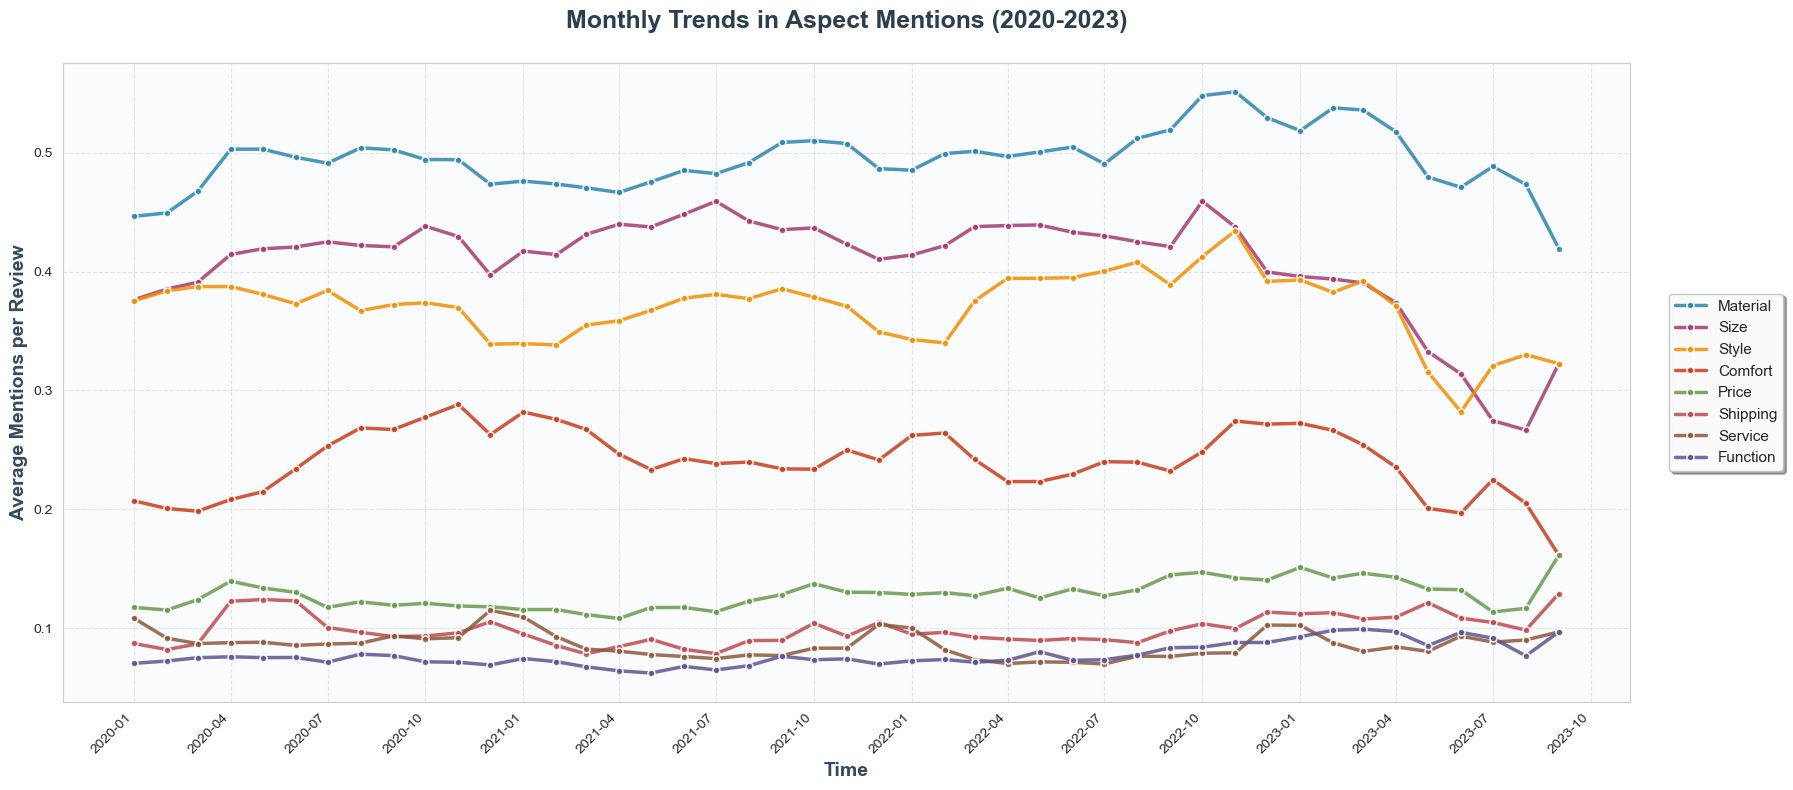

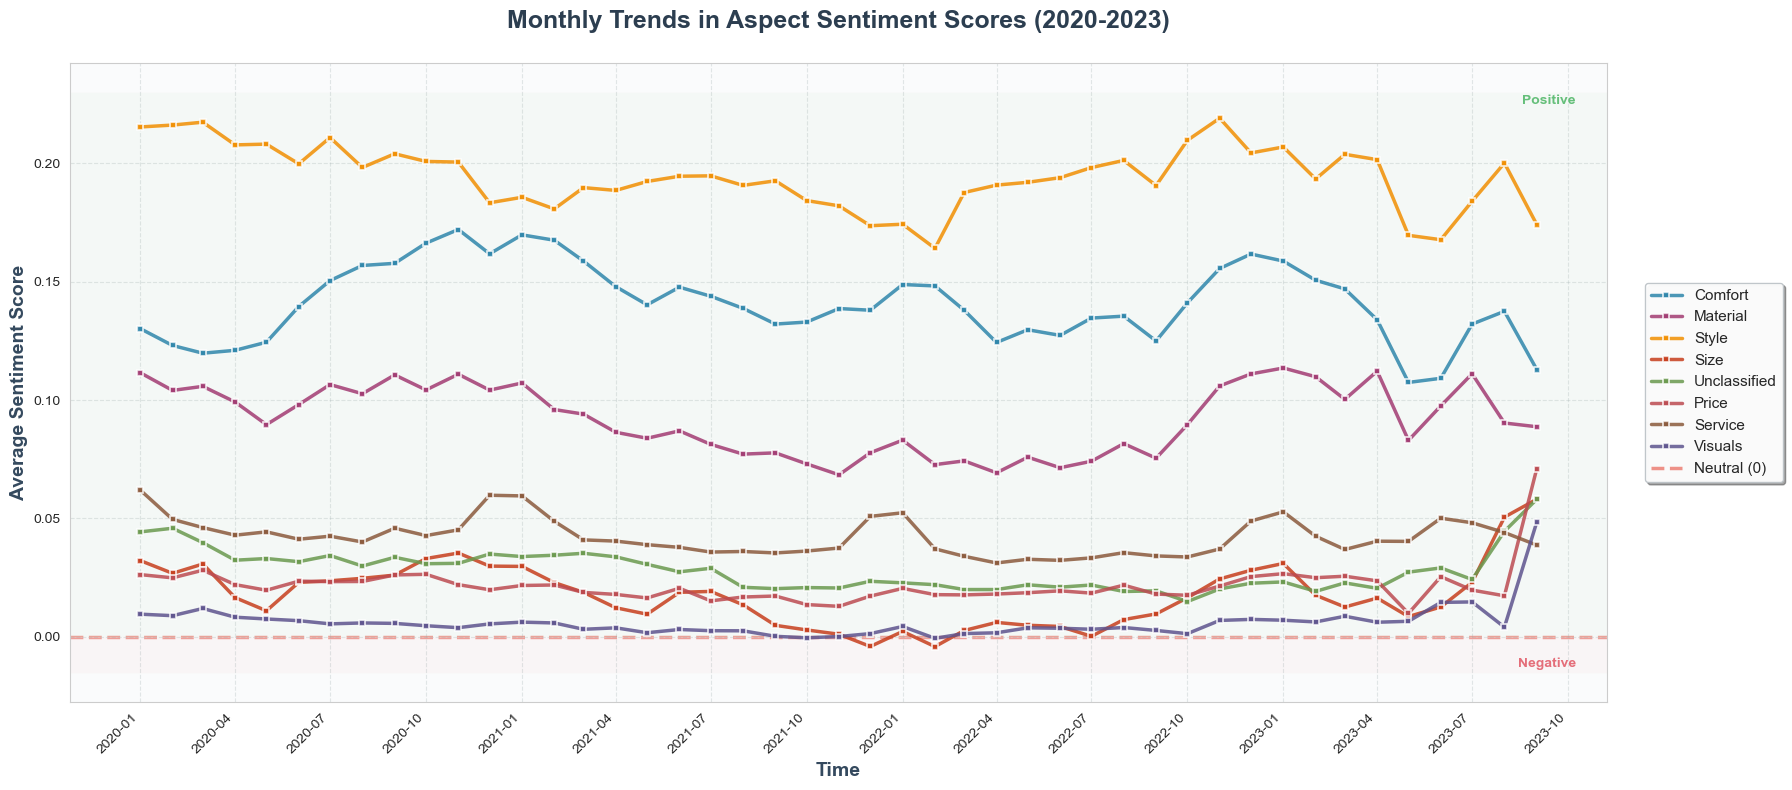

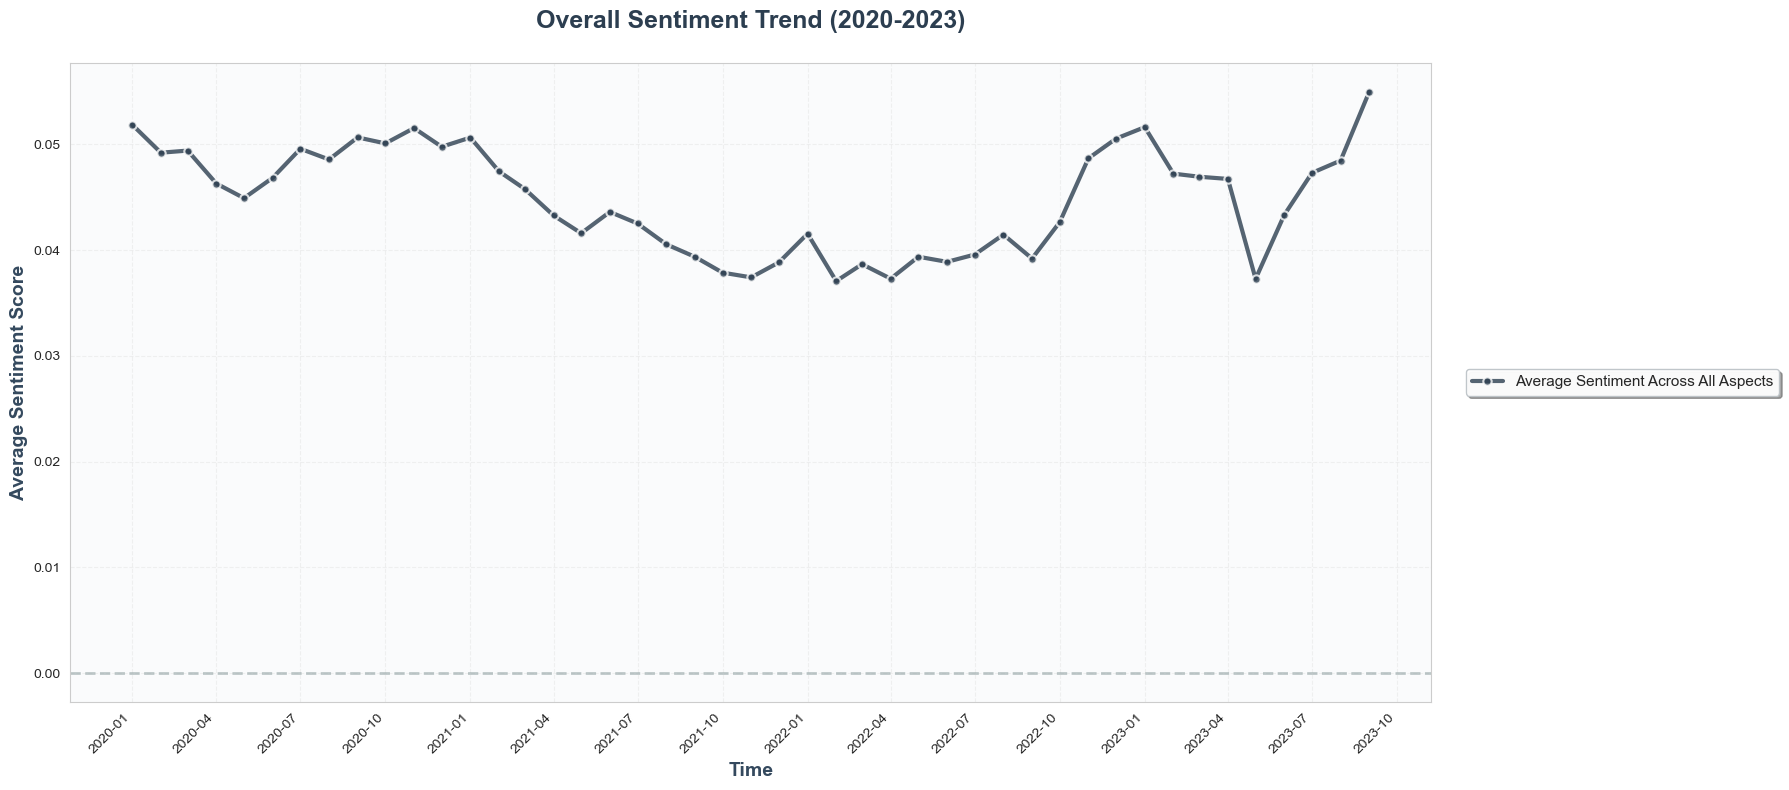

✅ Full timeline visualization completed!
📊 Top aspects by mention frequency: ['Material', 'Size', 'Style', 'Comfort', 'Price', 'Shipping', 'Service', 'Function']
📈 Top aspects by sentiment variability: ['Comfort', 'Material', 'Style', 'Size', 'Unclassified', 'Price', 'Service', 'Visuals']


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

# Set global style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# ==========================================
# Chart 1: Average Aspect Mention Frequency by Month (Full Timeline)
# ==========================================

top_aspects_exist = monthly_exist[aspect_cols_exist].mean().nlargest(8).index.tolist()

colors_custom = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', 
                 '#6A994E', '#BC4B51', '#8B5A3C', '#5E548E']

# Adjust subplot layout to make room for legend
fig, ax = plt.subplots(figsize=(18, 8))

# Plot lines
for idx, col in enumerate(top_aspects_exist):
    ax.plot(monthly_exist['date'], monthly_exist[col], 
            label=col.replace('_exist', '').title(), 
            marker='o', linewidth=2.5, markersize=5, 
            color=colors_custom[idx], alpha=0.85,
            markeredgecolor='white', markeredgewidth=1.2)

# Title and labels
ax.set_title('Monthly Trends in Aspect Mentions (2020-2023)', 
             fontsize=18, fontweight='bold', pad=25, 
             color='#2c3e50')
ax.set_xlabel('Time', fontsize=14, fontweight='bold', color='#34495e')
ax.set_ylabel('Average Mentions per Review', fontsize=14, fontweight='bold', color='#34495e')

# X-axis date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

# Grid optimization
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, color='#95a5a6')
ax.set_axisbelow(True)

# Place legend outside the chart on the right
legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                   fontsize=11, framealpha=0.95, 
                   edgecolor='#bdc3c7', fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')

ax.set_facecolor('#fafbfc')

plt.tight_layout()
plt.show()


# ==========================================
# Chart 2: Average Aspect Sentiment Scores by Month (Full Timeline)
# ==========================================

sentiment_std = monthly_score[aspect_cols_score].std()
top_aspects_score = sentiment_std.nlargest(8).index.tolist()

fig, ax = plt.subplots(figsize=(18, 8))

# Plot lines
for idx, col in enumerate(top_aspects_score):
    ax.plot(monthly_score['date'], monthly_score[col], 
            label=col.replace('_score', '').title(), 
            marker='s', linewidth=2.5, markersize=5, 
            color=colors_custom[idx], alpha=0.85,
            markeredgecolor='white', markeredgewidth=1.2)

# Title and labels
ax.set_title('Monthly Trends in Aspect Sentiment Scores (2020-2023)', 
             fontsize=18, fontweight='bold', pad=25, 
             color='#2c3e50')
ax.set_xlabel('Time', fontsize=14, fontweight='bold', color='#34495e')
ax.set_ylabel('Average Sentiment Score', fontsize=14, fontweight='bold', color='#34495e')

# X-axis date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

# Neutral line (zero line)
ax.axhline(y=0, color='#e74c3c', linestyle='--', linewidth=2.5, 
           alpha=0.6, label='Neutral (0)', zorder=0)

# Add background color for positive/negative sentiment zones
y_min, y_max = ax.get_ylim()
ax.axhspan(0, y_max, facecolor='#d4edda', alpha=0.15, zorder=0)
ax.axhspan(y_min, 0, facecolor='#f8d7da', alpha=0.15, zorder=0)

# Grid optimization
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, color='#95a5a6')
ax.set_axisbelow(True)

# Place legend outside the chart on the right
legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                   fontsize=11, framealpha=0.95, 
                   edgecolor='#bdc3c7', fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')

ax.set_facecolor('#fafbfc')

# Add sentiment zone labels
ax.text(0.98, 0.95, 'Positive', 
        fontsize=10, color='#28a745', alpha=0.7, fontweight='bold',
        ha='right', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05, 'Negative', 
        fontsize=10, color='#dc3545', alpha=0.7, fontweight='bold',
        ha='right', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()


# ==========================================
# Chart 3: Add COVID-19 Pandemic Annotation (Optional)
# ==========================================

fig, ax = plt.subplots(figsize=(18, 8))

# Plot average sentiment across all aspects
avg_sentiment = monthly_score[aspect_cols_score].mean(axis=1)

ax.plot(monthly_score['date'], avg_sentiment, 
        linewidth=3, color='#2c3e50', alpha=0.8,
        marker='o', markersize=6, markeredgecolor='white', markeredgewidth=1.5,
        label='Average Sentiment Across All Aspects')

# Add important event annotation
import pandas as pd


# Title
ax.set_title('Overall Sentiment Trend (2020-2023)', 
             fontsize=18, fontweight='bold', pad=25, color='#2c3e50')
ax.set_xlabel('Time', fontsize=14, fontweight='bold', color='#34495e')
ax.set_ylabel('Average Sentiment Score', fontsize=14, fontweight='bold', color='#34495e')

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

# Zero line
ax.axhline(y=0, color='#95a5a6', linestyle='--', linewidth=2, alpha=0.6)

ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)

# Place legend outside the chart on the right
legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                   fontsize=11, framealpha=0.95,
                   edgecolor='#bdc3c7', fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')

ax.set_facecolor('#fafbfc')

plt.tight_layout()
plt.show()

print("✅ Full timeline visualization completed!")
print(f"📊 Top aspects by mention frequency: {[a.replace('_exist','') for a in top_aspects_exist]}")
print(f"📈 Top aspects by sentiment variability: {[a.replace('_score','') for a in top_aspects_score]}")

#### 3. Store-wise comparison

In [55]:
top_stores = merged_use['store'].value_counts().nlargest(10).index
df_top = merged_use[merged_use['store'].isin(top_stores)]

aspect_cols_exist = [c for c in merged_use.columns if c.endswith('_exist')]
aspect_cols_score = [c for c in merged_use.columns if c.endswith('_score')]

store_exist = df_top.groupby('store')[aspect_cols_exist].mean().reset_index()
store_score = df_top.groupby('store')[aspect_cols_score].mean().reset_index()

store_summary = pd.merge(store_exist, store_score, on='store', suffixes=('_freq', '_sent'))



In [56]:
store_summary

,store,Unclassified_exist,Clips_exist,Comfort_exist,Service_exist,Print_exist,Function_exist,Washing_exist,Visuals_exist,Style_exist,...,Service_score,Print_score,Function_score,Washing_score,Visuals_score,Style_score,Price_score,Shipping_score,Material_score,Size_score
0,Casio,0.118483,0.002230,0.124338,0.060775,0.003067,0.287148,0.011709,0.056036,0.316978,...,0.026749,-0.000613,8.029923e-02,5.157513e-03,0.000781,0.171030,0.089462,0.018706,0.055910,-0.025420
1,Ekouaer,0.043230,0.000000,0.555913,0.025723,0.014291,0.020364,0.116113,0.032154,0.314398,...,0.010379,0.002715,-1.586600e-19,1.336191e-02,0.000661,0.143295,0.007574,0.003233,0.094811,0.053552
2,Floerns,0.046640,0.001054,0.147036,0.025033,0.021871,0.018182,0.026614,0.060606,0.583926,...,0.010013,0.010092,-5.494071e-03,-3.425560e-04,0.007207,0.289240,-0.003913,0.000171,-0.009061,-0.035070
3,GRACE KARIN,0.037536,0.000408,0.229294,0.024480,0.009180,0.019788,0.041004,0.053652,0.656263,...,0.012179,0.003856,-2.509180e-03,6.323949e-04,0.005926,0.328109,0.022501,0.004971,0.090395,0.062337
4,NELEUS,0.079805,0.000000,0.352490,0.026640,0.002094,0.033388,0.050605,0.012680,0.243136,...,0.010988,0.000076,1.512331e-02,7.835040e-03,-0.000436,0.115168,0.038721,0.006020,0.117873,0.066719
5,Romwe,0.044560,0.000547,0.171405,0.033078,0.021323,0.013122,0.042920,0.053581,0.557682,...,0.016758,0.007654,-4.893384e-03,2.720066e-03,0.004921,0.278328,0.006042,-0.003691,0.012381,-0.026668
6,SATINIOR,0.074709,0.003062,0.292713,0.071035,0.008573,0.064605,0.058788,0.030618,0.264850,...,0.035181,0.000827,1.857012e-02,-4.419136e-19,0.000245,0.140937,0.032685,0.013166,0.030996,-0.002113
7,SheIn,0.044184,0.001202,0.158100,0.021942,0.015029,0.018936,0.026450,0.056207,0.564773,...,0.010189,0.004569,-5.004509e-03,-1.232341e-03,-0.002329,0.253521,-0.002074,-0.000496,0.008551,-0.029835
8,SweatyRocks,0.038621,0.000319,0.204277,0.041494,0.022662,0.014044,0.048516,0.055538,0.481009,...,0.019167,0.005761,-6.383658e-04,1.548037e-03,0.009224,0.224861,-0.000287,0.003894,-0.002952,-0.041696
9,Verdusa,0.036575,0.000634,0.210148,0.020085,0.005497,0.014376,0.035729,0.068499,0.594715,...,0.008055,0.001924,-1.913319e-03,2.114165e-03,0.001184,0.292628,0.010074,0.001438,0.040644,-0.001709


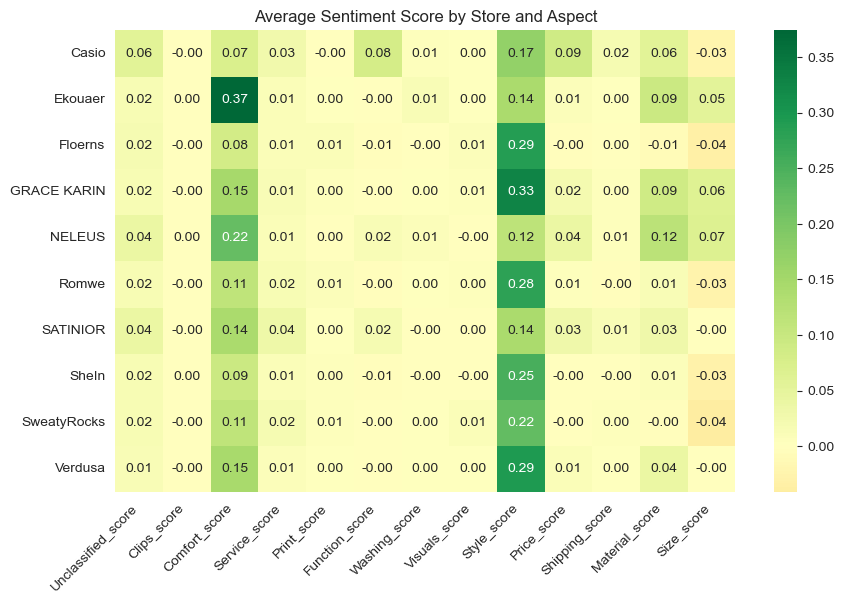

In [57]:

plt.figure(figsize=(10,6))
sns.heatmap(
    store_score.set_index('store'),
    cmap='RdYlGn', center=0, annot=True, fmt=".2f",   
)
plt.title("Average Sentiment Score by Store and Aspect")
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.show()


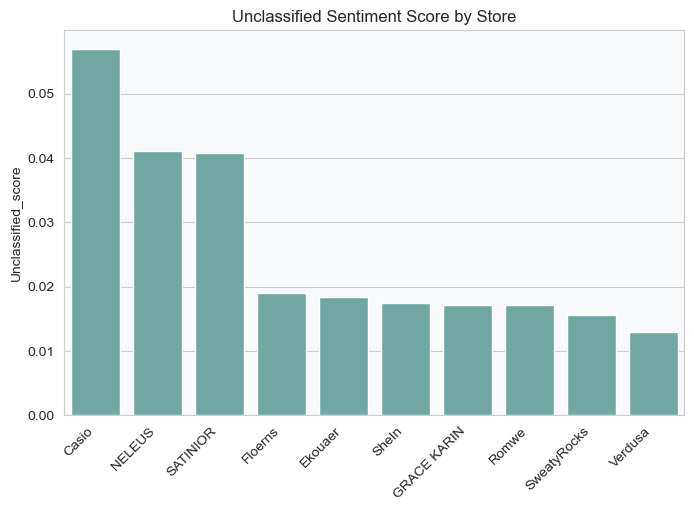

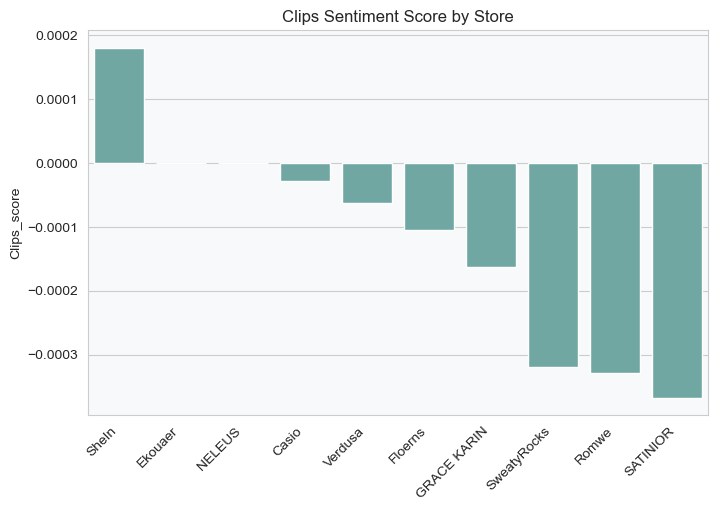

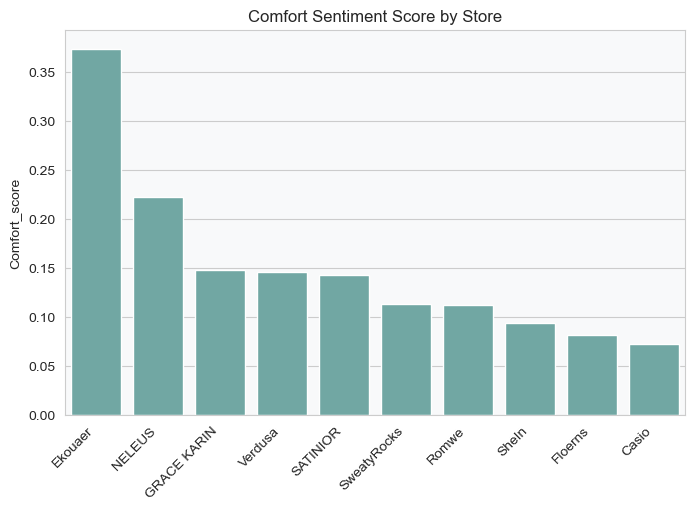

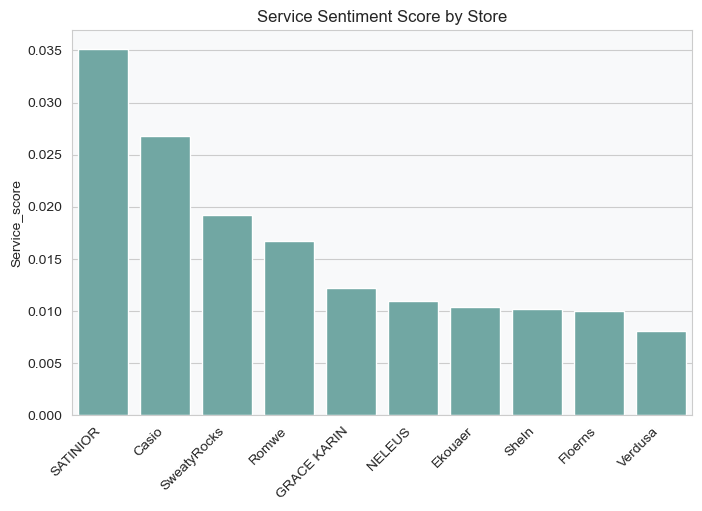

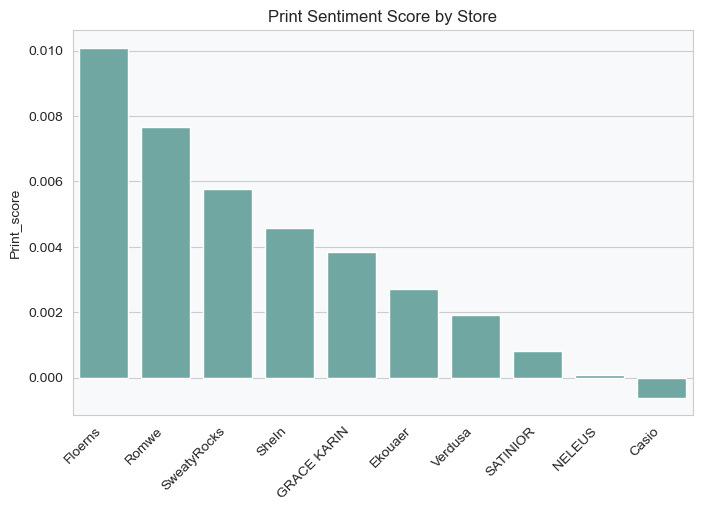

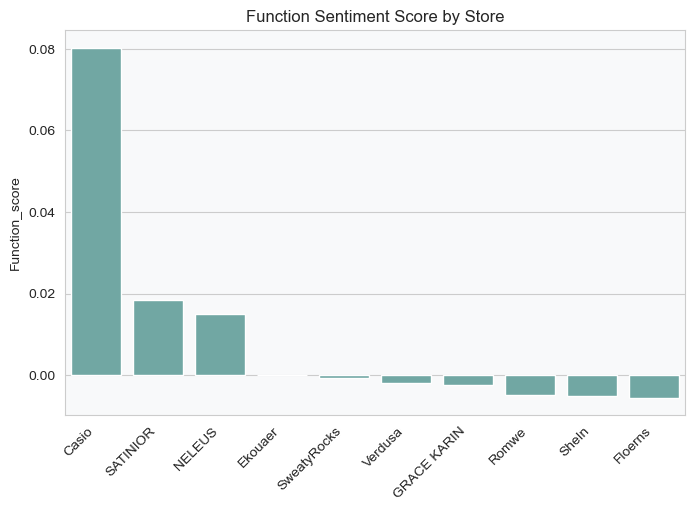

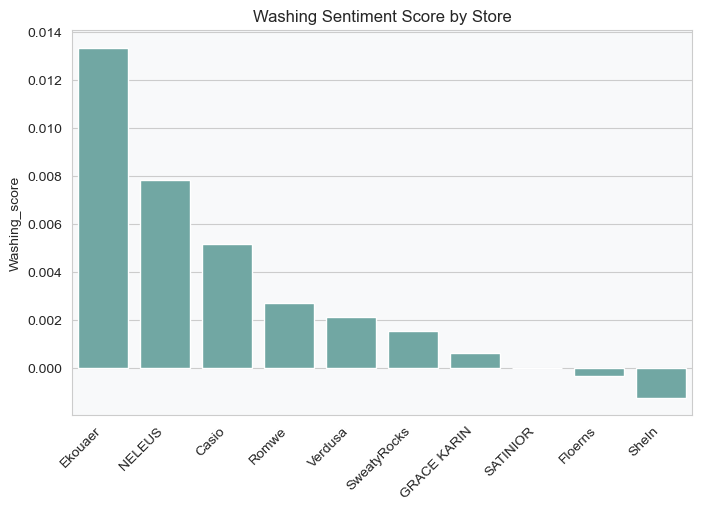

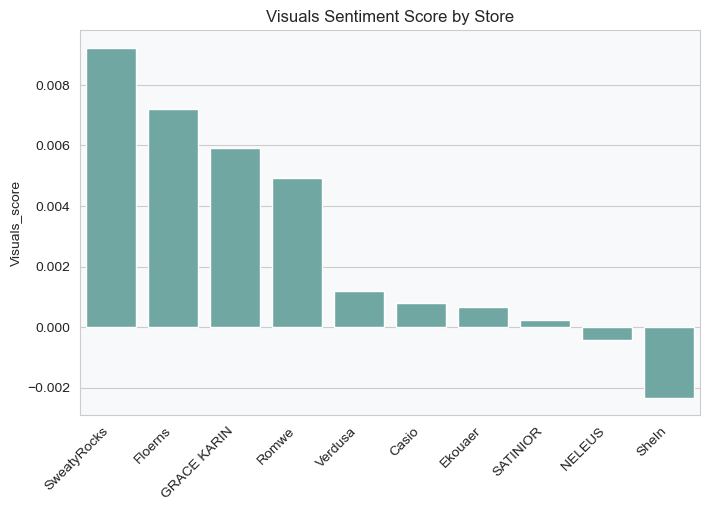

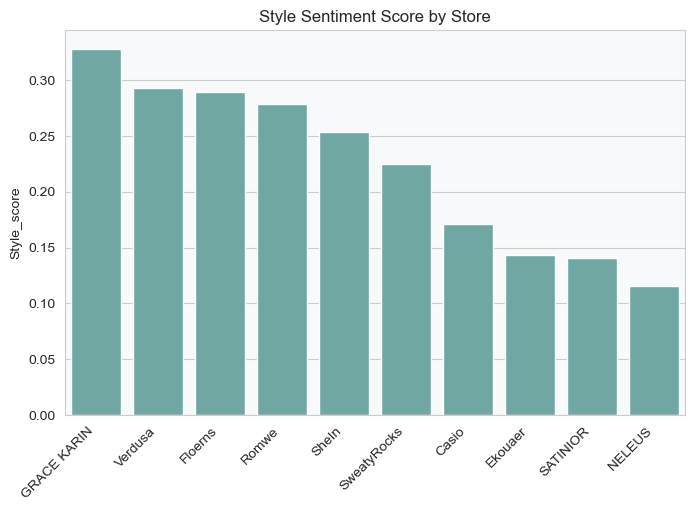

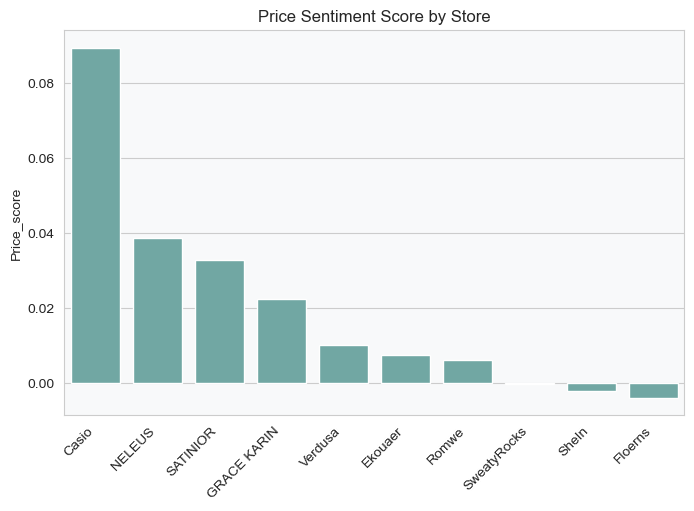

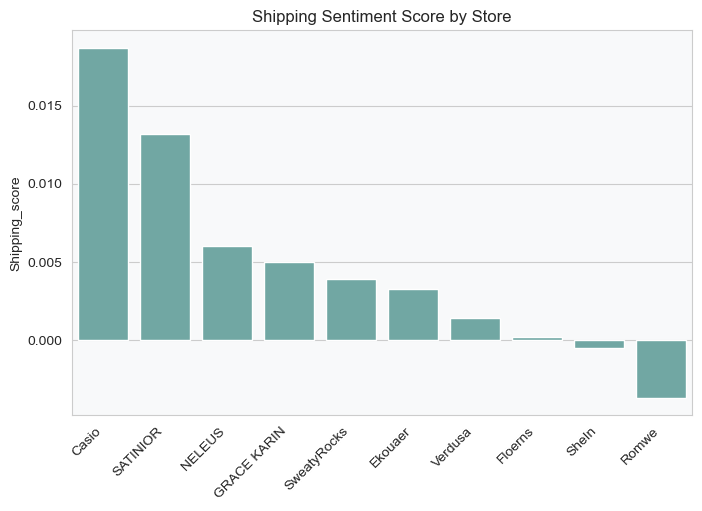

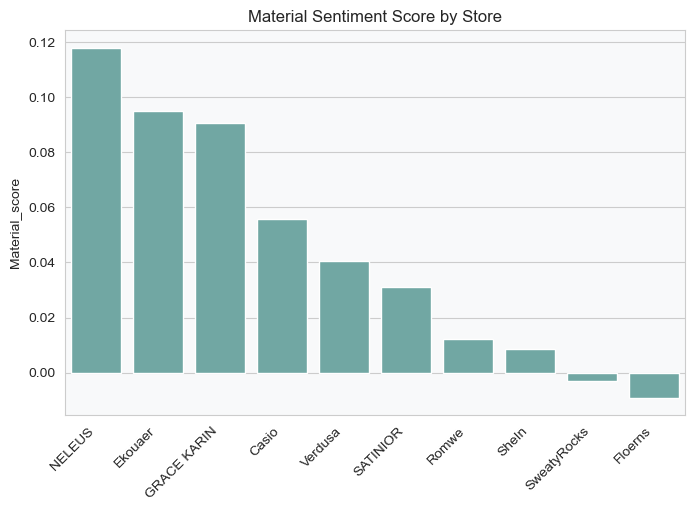

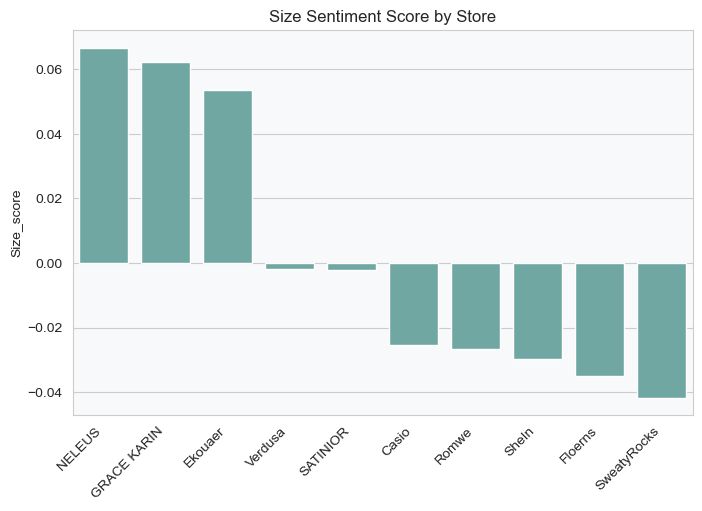

In [58]:
for aspect in target_aspects:
    plt.figure(figsize=(8,5))
    sns.barplot(
        data=store_score,
        x='store', y=f'{aspect}_score',
        color='#68b0ab',
        order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
    )
    plt.title(f"{aspect} Sentiment Score by Store")
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [59]:
score_cols = [c for c in store_score.columns if c.endswith('_score')]
store_score['avg_sentiment'] = store_score[score_cols].mean(axis=1)


In [60]:
store_score.sort_values('avg_sentiment', ascending=False).head()


,store,Unclassified_score,Clips_score,Comfort_score,Service_score,Print_score,Function_score,Washing_score,Visuals_score,Style_score,Price_score,Shipping_score,Material_score,Size_score,avg_sentiment
1,Ekouaer,0.018382,0.000000,0.374345,0.010379,0.002715,-1.586600e-19,0.013362,0.000661,0.143295,0.007574,0.003233,0.094811,0.053552,0.055562
3,GRACE KARIN,0.017136,-0.000163,0.147800,0.012179,0.003856,-2.509180e-03,0.000632,0.005926,0.328109,0.022501,0.004971,0.090395,0.062337,0.053321
4,NELEUS,0.041054,0.000000,0.222852,0.010988,0.000076,1.512331e-02,0.007835,-0.000436,0.115168,0.038721,0.006020,0.117873,0.066719,0.049384
0,Casio,0.057039,-0.000028,0.072965,0.026749,-0.000613,8.029923e-02,0.005158,0.000781,0.171030,0.089462,0.018706,0.055910,-0.025420,0.042464
9,Verdusa,0.013002,-0.000063,0.145910,0.008055,0.001924,-1.913319e-03,0.002114,0.001184,0.292628,0.010074,0.001438,0.040644,-0.001709,0.039484


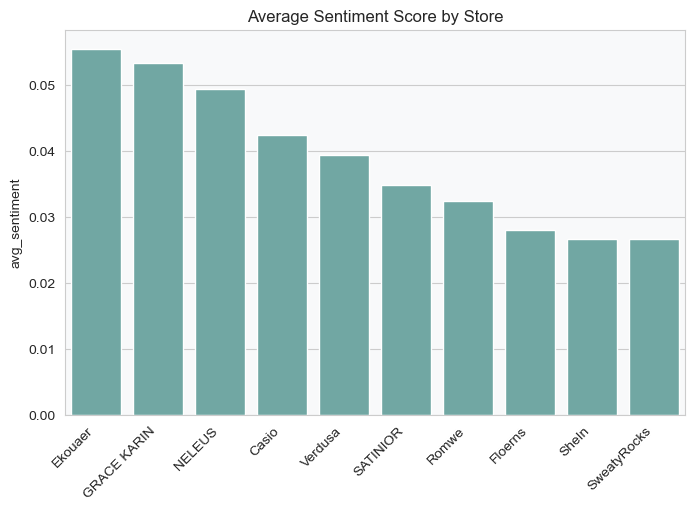

In [61]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'avg_sentiment',
    color='#68b0ab',
    order=store_score.sort_values('avg_sentiment', ascending=False)['store']
)
plt.title("Average Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

#### RQ1: Which text feature aspects most strongly influence star ratings

apply linear regression as a baseline model

In [62]:
merged_use.columns

Index(['parent_asin', 'store', 'timestamp', 'user_id', 'rating', 'text',
       'helpful_vote', 'verified_purchase', 'aspect', 'sentiment', 'score',
       'helpful_binary', 'Unclassified_exist', 'Unclassified_score',
       'Clips_exist', 'Clips_score', 'Comfort_exist', 'Comfort_score',
       'Service_exist', 'Service_score', 'Print_exist', 'Print_score',
       'Function_exist', 'Function_score', 'Washing_exist', 'Washing_score',
       'Visuals_exist', 'Visuals_score', 'Style_exist', 'Style_score',
       'Price_exist', 'Price_score', 'Shipping_exist', 'Shipping_score',
       'Material_exist', 'Material_score', 'Size_exist', 'Size_score',
       'year_month'],
      dtype='object')

In [63]:

# extract year and month separately
merged_use['year'] = merged_use['timestamp'].dt.year
merged_use['month'] = merged_use['timestamp'].dt.month


/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/454645893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['year'] = merged_use['timestamp'].dt.year
/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/454645893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['month'] = merged_use['timestamp'].dt.month


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

aspect_features = [
    'Unclassified_exist', 'Unclassified_score',
       'Clips_exist', 'Clips_score', 'Comfort_exist', 'Comfort_score',
       'Service_exist', 'Service_score', 'Print_exist', 'Print_score',
       'Function_exist', 'Function_score', 'Washing_exist', 'Washing_score',
       'Visuals_exist', 'Visuals_score', 'Style_exist', 'Style_score',
       'Price_exist', 'Price_score', 'Shipping_exist', 'Shipping_score',
       'Material_exist', 'Material_score', 'Size_exist', 'Size_score'
]
meta_features = ['verified_purchase', 'year', 'month']

target = 'rating'

X = merged_use[aspect_features + meta_features].copy()
y = merged_use[target]

# Fill NaN values with 0
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


linreg = LinearRegression()

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R²: {r2:.4f}")

Linear Regression RMSE: 1.0390
Linear Regression R²: 0.5252


R_square is pretty low, considering using machine learning models to improve performance.

Extreme Gradient Boosting (XGBoost) - an open-source machine learning software library that provides an efficient, flexible, and portable implementation of the gradient boosting algorithm. 

XGBRegressor implements the XGBoost algorithm, known for its efficiency and performance in machine learning. It builds an ensemble of decision trees sequentially, where each new tree corrects the errors of the preceding ones.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [66]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
        'n_estimators': [300, 500, 800],        # Number of trees
        'learning_rate': [0.01, 0.05],          # Step size shrinkage
        'max_depth': [3, 5, 7],                 # Maximum depth of a tree
        'subsample': [0.7, 0.8],                # Subsample ratio of the training instances
        'colsample_bytree': [0.6, 0.8],         # Subsample ratio of columns when constructing each tree
        'reg_alpha': [0.1, 1, 5],               # L1 regularization term on weights (Good for sparse features)
        'reg_lambda': [1, 2],                   # L2 regularization term on weights
        'min_child_weight': [1, 3, 5]           # Minimum sum of instance weight (hessian) needed in a child
    }

# Initialize XGBRegressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Randomized Search
search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=15, # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
search.fit(X_train, y_train)

# Output Best Parameters
print("\n🏆 Best Parameters Found:")
print(search.best_params_)
print(f"Best CV MSE: {-search.best_score_:.4f}")

# ==========================================
# 3. Final Model Evaluation & Analysis
# ==========================================

best_model = search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Test Set Evaluation:")
print(f"   MSE: {mse:.4f}")
print(f"   R2 Score: {r2:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

🏆 Best Parameters Found:
{'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV MSE: 0.7761

📊 Test Set Evaluation:
   MSE: 0.7763
   R2 Score: 0.6586


/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/453301215.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gain', y='Feature', data=importance_df, palette='viridis')


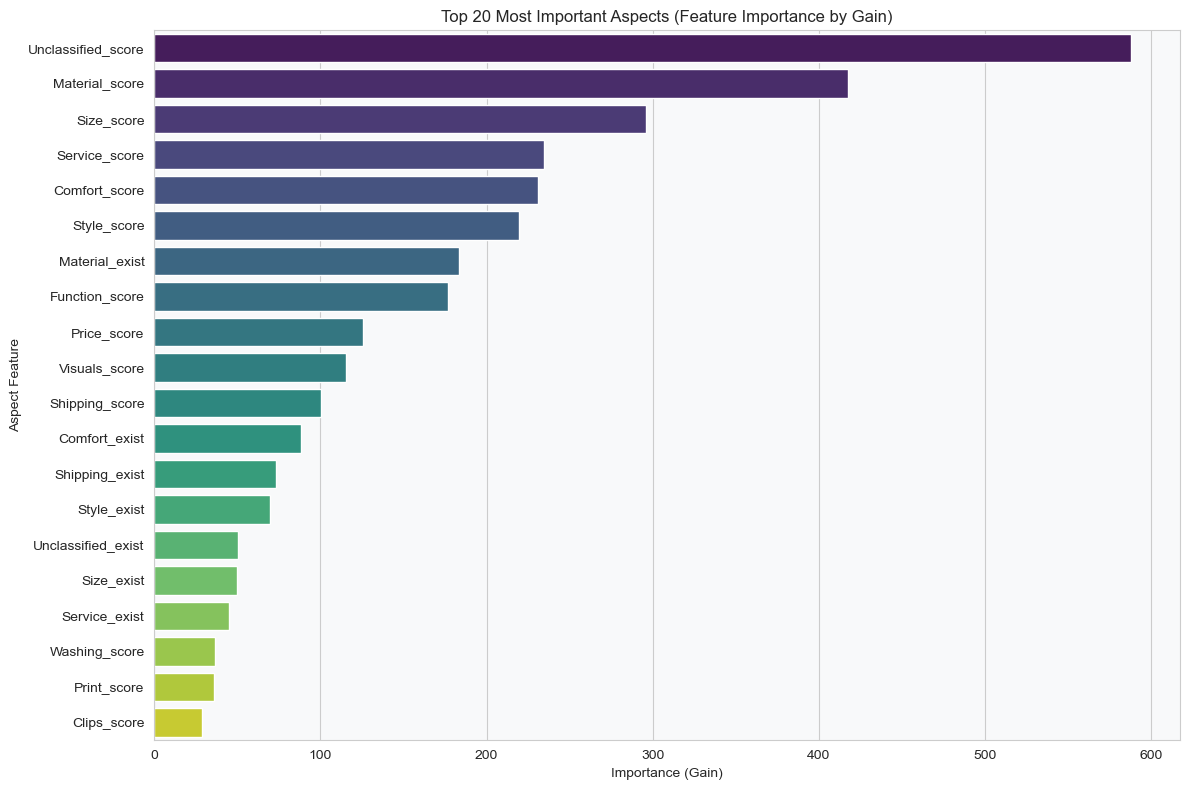


💡 Interpretation Guide:
1. High 'Score_XXX' importance: The *sentiment* (pos/neg) of this aspect drives the rating.
2. High 'Exist_XXX' importance: Just *mentioning* this aspect affects the rating (e.g., mentioning 'Shipping' might correlate with negative ratings regardless of sentiment score if the model finds it predictive).


In [67]:
# Feature Importance Visualization
# 'Gain' implies the relative contribution of the corresponding feature to the model 
importance = best_model.get_booster().get_score(importance_type='gain')

if importance:
    importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
    importance_df = importance_df.sort_values(by='Gain', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Gain', y='Feature', data=importance_df, palette='viridis')
    plt.title('Top 20 Most Important Aspects (Feature Importance by Gain)')
    plt.xlabel('Importance (Gain)')
    plt.ylabel('Aspect Feature')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No feature importance scores available (Model might be constant).")

print("\n💡 Interpretation Guide:")
print("1. High 'Score_XXX' importance: The *sentiment* (pos/neg) of this aspect drives the rating.")
print("2. High 'Exist_XXX' importance: Just *mentioning* this aspect affects the rating (e.g., mentioning 'Shipping' might correlate with negative ratings regardless of sentiment score if the model finds it predictive).")



#### RQ2: Which text feature aspects mostly predict review helpfulness(0-1 binary)

In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

aspect_features = [
    'Unclassified_exist', 'Unclassified_score',
       'Clips_exist', 'Clips_score', 'Comfort_exist', 'Comfort_score',
       'Service_exist', 'Service_score', 'Print_exist', 'Print_score',
       'Function_exist', 'Function_score', 'Washing_exist', 'Washing_score',
       'Visuals_exist', 'Visuals_score', 'Style_exist', 'Style_score',
       'Price_exist', 'Price_score', 'Shipping_exist', 'Shipping_score',
       'Material_exist', 'Material_score', 'Size_exist', 'Size_score'
]

meta_features = ['verified_purchase', 'rating', 'year', 'month']
features = aspect_features + meta_features
target = 'helpful_binary'

X = merged_use[features].copy()
y = merged_use[target].astype(int).copy()

X = X.fillna(0)
for c in X.columns:
    if X[c].dtype == 'bool':
        X[c] = X[c].astype(int)

pos = y.sum()
neg = len(y) - pos
print(f"Positive(helpful=1): {pos}, Negative(helpful=0): {neg}, ratio pos/neg = {pos/neg:.3f}")

scale_pos_weight = neg / (pos + 1e-9)
print(scale_pos_weight)


Positive(helpful=1): 133153, Negative(helpful=0): 695296, ratio pos/neg = 0.192
5.221782460778163



🔍 Starting RandomizedSearchCV for XGBClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

🏆 Best Parameters Found:
{'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 5, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV ROC-AUC: 0.6359

📊 Test Set Evaluation:
   ROC-AUC: 0.6386
   F1 Score: 0.3231

   Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.63      0.73    139059
           1       0.23      0.57      0.32     26631

    accuracy                           0.62    165690
   macro avg       0.55      0.60      0.53    165690
weighted avg       0.78      0.62      0.67    165690



/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/3705988366.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gain', y='Feature', data=importance_df, palette='magma')


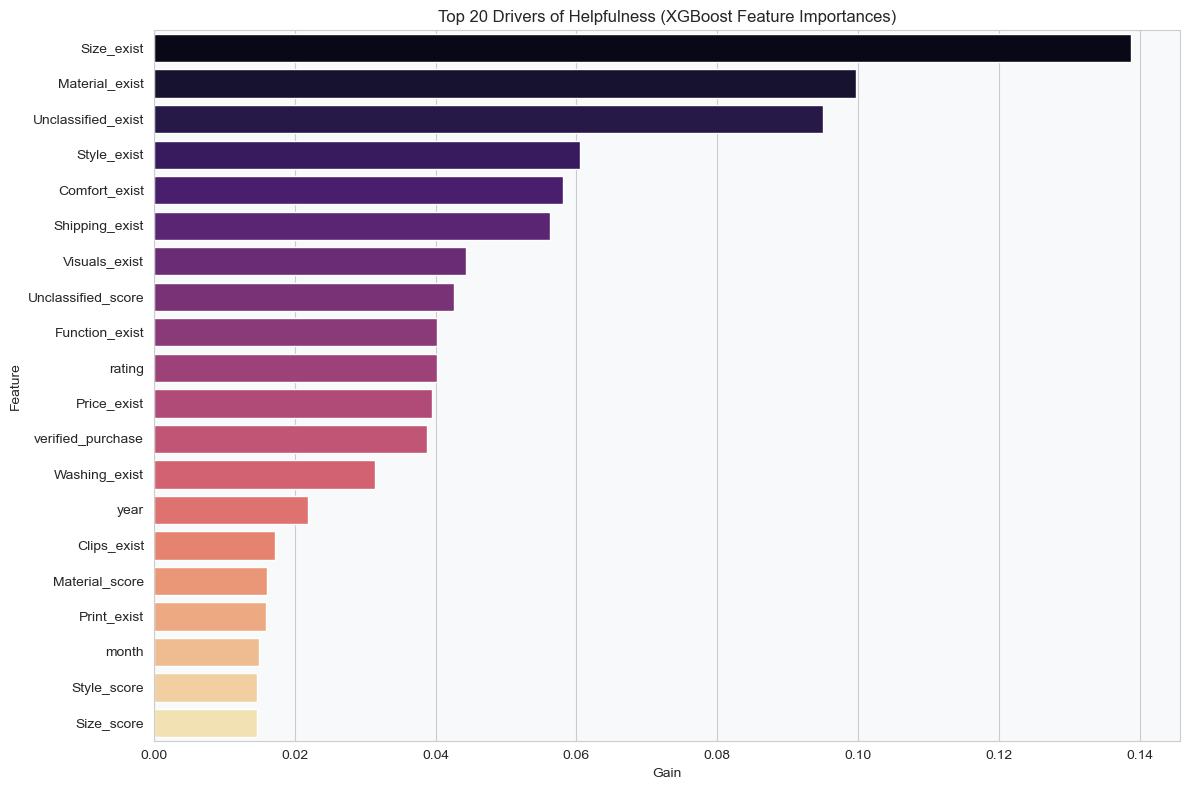

In [69]:
# ==========================================
# XGBClassifier Hyperparameter Tuning
# ==========================================

if not X.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\n🔍 Starting RandomizedSearchCV for XGBClassifier...")

    param_grid = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0.1, 1, 5],
        'reg_lambda': [1, 2],
        'min_child_weight': [1, 3, 5],
    }

    xgb_clf = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_grid,
        n_iter=15,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=3),
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print("\n🏆 Best Parameters Found:")
    print(search.best_params_)
    print(f"Best CV ROC-AUC: {search.best_score_:.4f}")

    # ==========================================
    # 3. Final Evaluation
    # ==========================================
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📊 Test Set Evaluation:")
    print(f"   ROC-AUC: {auc:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred))

    # ==========================================
    # Feature Importance (Safe Version)
    # ==========================================

    importance = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Gain': importance
    }).sort_values(by='Gain', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Gain', y='Feature', data=importance_df, palette='magma')
    plt.title('Top 20 Drivers of Helpfulness (XGBoost Feature Importances)')
    plt.tight_layout()
    plt.show()

else:
    print("Skipping classification due to empty data.")


Try LightGBM

In [70]:
!pip install lightgbm


🔍 Starting RandomizedSearchCV for LGBMClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

🏆 Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV ROC-AUC: 0.6357

📊 Test Set Evaluation:
   ROC-AUC: 0.6383
   F1 Score: 0.3220

   Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73    139059
           1       0.22      0.57      0.32     26631

    accuracy                           0.61    165690
   macro avg       0.55      0.60      0.52    165690
weighted avg       0.78      0.61      0.66    165690



/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_93801/3560124085.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gain', y='Feature', data=importance_df, palette='magma')


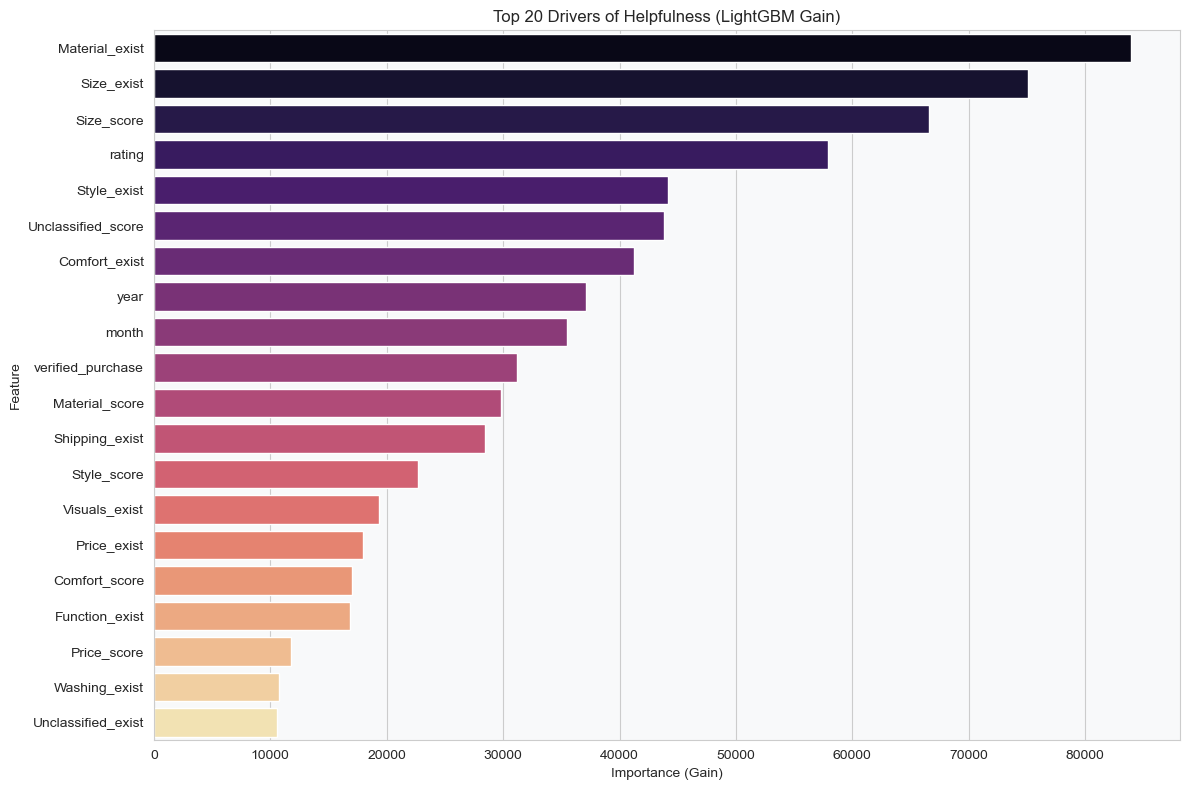


💡 Classification Insight:
This LightGBM model identifies which aspects make a review 'Helpful'.
- High importance features indicate what users look for when voting a review as helpful.
- 'verified_purchase' is often a strong predictor.
- LightGBM advantages: Faster training, lower memory usage, better handling of categorical features.


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, r2_score

# 2. LGBMClassifier Hyperparameter Tuning
# ==========================================

if not X.empty:
    # Split data (Stratified due to potential imbalance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\n🔍 Starting RandomizedSearchCV for LGBMClassifier...")

    # LightGBM Parameter Grid
    param_grid = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, -1],  # -1 means no limit
        'num_leaves': [31, 50, 100],  # LightGBM-specific: max number of leaves in one tree
        'subsample': [0.7, 0.8, 1.0],  # Also called bagging_fraction
        'colsample_bytree': [0.6, 0.8, 1.0],  # Also called feature_fraction
        'min_child_samples': [20, 30, 50],  # Minimum number of data in one leaf
        'reg_alpha': [0.1, 1, 5],  # L1 regularization
        'reg_lambda': [1, 2, 5],  # L2 regularization
    }

    # Initialize LGBMClassifier
    # IMPORTANT: Passing scale_pos_weight (or is_unbalance) to handle imbalance
    lgbm_clf = LGBMClassifier(
        objective='binary',
        metric='auc',
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=42,
        n_jobs=-1,
        verbose=-1  # Suppress warnings during training
    )

    # Search
    search = RandomizedSearchCV(
        estimator=lgbm_clf,
        param_distributions=param_grid,
        n_iter=15,
        scoring='roc_auc',  # Optimize for AUC
        cv=StratifiedKFold(n_splits=3),  # Use Stratified CV for classification
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print("\n🏆 Best Parameters Found:")
    print(search.best_params_)
    print(f"Best CV ROC-AUC: {search.best_score_:.4f}")

    # ==========================================
    # 3. Final Evaluation
    # ==========================================

    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for positive class

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📊 Test Set Evaluation:")
    print(f"   ROC-AUC: {auc:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred))

    # Feature Importance (Gain)
    importance_gain = best_model.booster_.feature_importance(importance_type='gain')
    feature_names = best_model.feature_name_

    if len(importance_gain) > 0:
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Gain': importance_gain
        })
        importance_df = importance_df.sort_values(by='Gain', ascending=False).head(20)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Gain', y='Feature', data=importance_df, palette='magma')
        plt.title('Top 20 Drivers of Helpfulness (LightGBM Gain)')
        plt.xlabel('Importance (Gain)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No feature importance scores available.")

    print("\n💡 Classification Insight:")
    print("This LightGBM model identifies which aspects make a review 'Helpful'.")
    print("- High importance features indicate what users look for when voting a review as helpful.")
    print("- 'verified_purchase' is often a strong predictor.")
    print("- LightGBM advantages: Faster training, lower memory usage, better handling of categorical features.")

else:
    print("Skipping classification due to empty data.")